 
|Variable|Description|
|:-------|:--------|
|dswrf_sfc_wm2 | Net downward shortwave radiation flux|
|gust_sfc_ms | Wind gust surface (Böe)|
|hpbl_sfc_m | Planetary boundary layer height|
|msl_ms_pa | Mean sea level pressure|
|pottemp_80mto0m_K | Potential temperature difference between 80m and 0m|
|q_2m_1 | Specific humudity in 2 m height|
|q_pfg30_1 | Specific humidity mean over first 30 hPa (~250m)|
|r_pl925_% | Relative humidity in 925 hPa pressure level|
|r_pl950_% | Relative humidity in 950 hPa pressure level |
|shtfl_sfc_wm2 | Net sensible heat flux (conductive heat flux from the Earth's surface to the atmosphere)|
|t_100m_k | Temperature in 100 m height in Kelvin|
|t_2m_k | Temperature in 2 m height in Kelvin|
|t_pfg30_k | Temperature mean ober first 30 hPa (~250m) in Kelvin |
|tcclow_sfc_% | Total Cloud Cover, low level clouds (0km - 2km height)|
|tccmedium_sfc_% | Total Cloud Cover, medium level clouds (2km - 7km height)|
|wdir_100m_dn | wind direction in 100 m height in in degrees|
|wdir_10m_dn | wind direction in 10 m height in in degrees|
|wdir_pfg30_dn | wind direction mean over first 30 hPa (~250m) in degrees|
|wdir_pl925_dn | wind direction in 925 hPa pressure level in degrees|
|wsp_100m_ms | wind speed in 100 m height in meters/second|
|wsp_10m_ms | wind speed in 10 m height in meters/second |
|wsp_pfg30_ms | wind speed mean over first 30 hPa (~250m) in meters/second|
|wsp_pl925_ms | wind speed in 925 hPa pressure leben in meters/second|
|created_on | date and 24 hours divided in quarters|
|azimuth | shows the rotation of the wind turbine|
|elevation | heights of the sun|

In [297]:
reset -fs

# Loading Modules and Datasets

In [670]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score


import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [299]:
# reading in the first dataframe
with open('griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_fin = u.load()

In [300]:
# rename columns which contains symbols
df_fin = df_fin.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})
# converting to actual timezone
df_fin.index = df_fin.index.tz_convert(tz='Europe/Berlin')

# putting in the day name
df_fin['day_name'] = df_fin.index.day_name()
df_fin['day_name'] = df_fin['day_name'].astype('category')
df_fin['month_name'] = df_fin.index.month_name()
df_fin['month_name'] = df_fin['month_name'].astype('category')

In [301]:
# reading in the second dataframe
with open('obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_norm = u.load()


In [302]:
# converting to the same timezone as the first dataframe
df_norm.index = df_norm.index.tz_convert(tz='Europe/Berlin')

# resample 
df_norm = df_norm.resample('H').mean()

In [303]:
# combining both dataframes to have one to work in
df = pd.concat([df_norm,df_fin], axis=1)

In [304]:
df.columns

Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k', 't_pfg30_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pfg30_dn', 'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms',
       'wsp_pfg30_ms', 'wsp_pl925_ms', 'created_on', 'azimuth', 'elevation',
       'day_name', 'month_name'],
      dtype='object')

In [305]:
df

power_mw_obsnorm  power_available_mw_obsnorm  \
2018-01-01 00:00:00+01:00          0.345151                    0.467090   
2018-01-01 01:00:00+01:00          0.346501                    0.523755   
2018-01-01 02:00:00+01:00          0.395608                    0.645962   
2018-01-01 03:00:00+01:00          0.492804                    0.816580   
2018-01-01 04:00:00+01:00          0.457564                    0.869310   
2018-01-01 05:00:00+01:00          0.353023                    0.851951   
2018-01-01 06:00:00+01:00          0.468883                    0.917528   
2018-01-01 07:00:00+01:00          0.512503                    0.966921   
2018-01-01 08:00:00+01:00          0.450723                    0.979995   
2018-01-01 09:00:00+01:00          0.501776                    0.985792   
2018-01-01 10:00:00+01:00          0.457684                    0.975297   
2018-01-01 11:00:00+01:00          0.478561                    0.969752   
2018-01-01 12:00:00+01:00          0.614915                    0.942335   
2018-01-01 13:00:00+01:00          0.543529                    0.896562   
2018-01-01 14:00:00+01:00          0.527852                    0.826681   
2018-01-01 15:00:00+01:00          0.504725                    0.746743   
2018-01-01 16:00:00+01:00          0.478161                    0.724066   
2018-01-01 17:00:00+01:00          0.473546                    0.685484   
2018-01-01 18:00:00+01:00          0.466272                    0.685143   
2018-01-01 19:00:00+01:00          0.409668                    0.616172   
2018-01-01 20:00:00+01:00          0.347872                    0.529728   
2018-01-01 21:00:00+01:00          0.301633                    0.364234   
2018-01-01 22:00:00+01:00          0.255851                    0.301627   
2018-01-01 23:00:00+01:00          0.235155                    0.270539   
2018-01-02 00:00:00+01:00          0.231717                    0.256800   
2018-01-02 01:00:00+01:00          0.187186                    0.200682   
2018-01-02 02:00:00+01:00          0.141489                    0.154737   
2018-01-02 03:00:00+01:00          0.132878                    0.143084   
2018-01-02 04:00:00+01:00          0.162488                    0.173336   
2018-01-02 05:00:00+01:00          0.167674                    0.178162   
...                                     ...                         ...   
2019-08-25 15:00:00+02:00               NaN                         NaN   
2019-08-25 16:00:00+02:00               NaN                         NaN   
2019-08-25 17:00:00+02:00               NaN                         NaN   
2019-08-25 18:00:00+02:00               NaN                         NaN   
2019-08-25 19:00:00+02:00               NaN                         NaN   
2019-08-25 20:00:00+02:00               NaN                         NaN   
2019-08-25 21:00:00+02:00               NaN                         NaN   
2019-08-25 22:00:00+02:00               NaN                         NaN   
2019-08-25 23:00:00+02:00               NaN                         NaN   
2019-08-26 00:00:00+02:00               NaN                         NaN   
2019-08-26 01:00:00+02:00               NaN                         NaN   
2019-08-26 02:00:00+02:00               NaN                         NaN   
2019-08-26 03:00:00+02:00               NaN                         NaN   
2019-08-26 04:00:00+02:00               NaN                         NaN   
2019-08-26 05:00:00+02:00               NaN                         NaN   
2019-08-26 06:00:00+02:00               NaN                         NaN   
2019-08-26 07:00:00+02:00               NaN                         NaN   
2019-08-26 08:00:00+02:00               NaN                         NaN   
2019-08-26 09:00:00+02:00               NaN                         NaN   
2019-08-26 10:00:00+02:00               NaN                         NaN   
2019-08-26 11:00:00+02:00               NaN                         NaN   
2019-08-26 12:00:00+02:00               NaN         

# Data Cleaning

In [306]:
# drop rows with NaN
df = df.dropna()

In [307]:
# mean and max difference between windspeed in 100m height and after first 30 hPA
diff_wsp = (abs(df['wsp_pfg30_ms']-df['wsp_100m_ms']))
diff_wsp = pd.DataFrame(diff_wsp)
print(diff_wsp[0].mean())
print(diff_wsp[0].max())

0.1536279734876543
0.7652005515770703


In [308]:
# mean and max difference between wind direction in 100m height and after first 30 hPA
diff_wdir = (df['wdir_pfg30_dn']-df['wdir_100m_dn'])
diff_wdir = pd.DataFrame(diff_wdir)
print(diff_wdir[0].mean())
print(diff_wdir[0].max())

-0.46668661290137636
91.2075218095992


In [309]:
# mean and max difference between temperatures in 100m height and after first 30 hPA
diff_t = (df['t_pfg30_k']-df['t_100m_k'])
diff_t = pd.DataFrame(diff_t)
print(diff_t[0].mean())
print(diff_t[0].max())

-0.07007108977168922
0.75


In [310]:
# dropping columns for after first 30 hPa since 100m is nearly the same height
if 'wsp_pfg30_ms' in df.columns:
    df.pop('wsp_pfg30_ms')
    df.pop('wdir_pfg30_dn')
    df.pop('t_pfg30_k')
    print(df.columns)

Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms',
       'created_on', 'azimuth', 'elevation', 'day_name', 'month_name'],
      dtype='object')


# Data Exploration

## Correlation matrix and heatmap

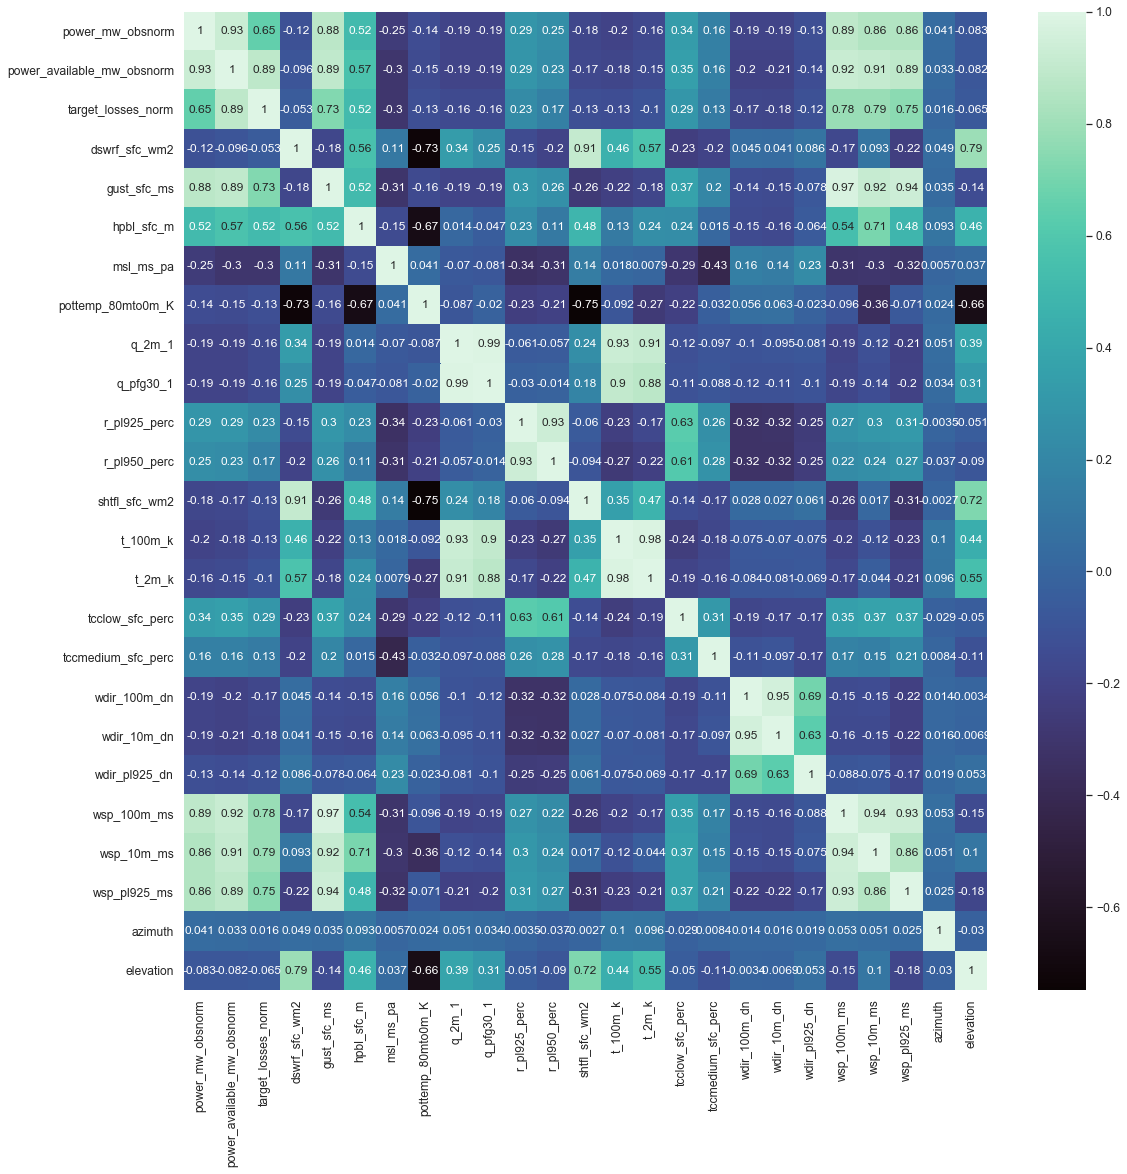

In [311]:
# correalation matrix
plt.figure(figsize=(18,18))
sns.set(font_scale=1.1)
sns.heatmap(df.corr(), cmap='mako', annot=True, annot_kws={'size':12})
plt.show()

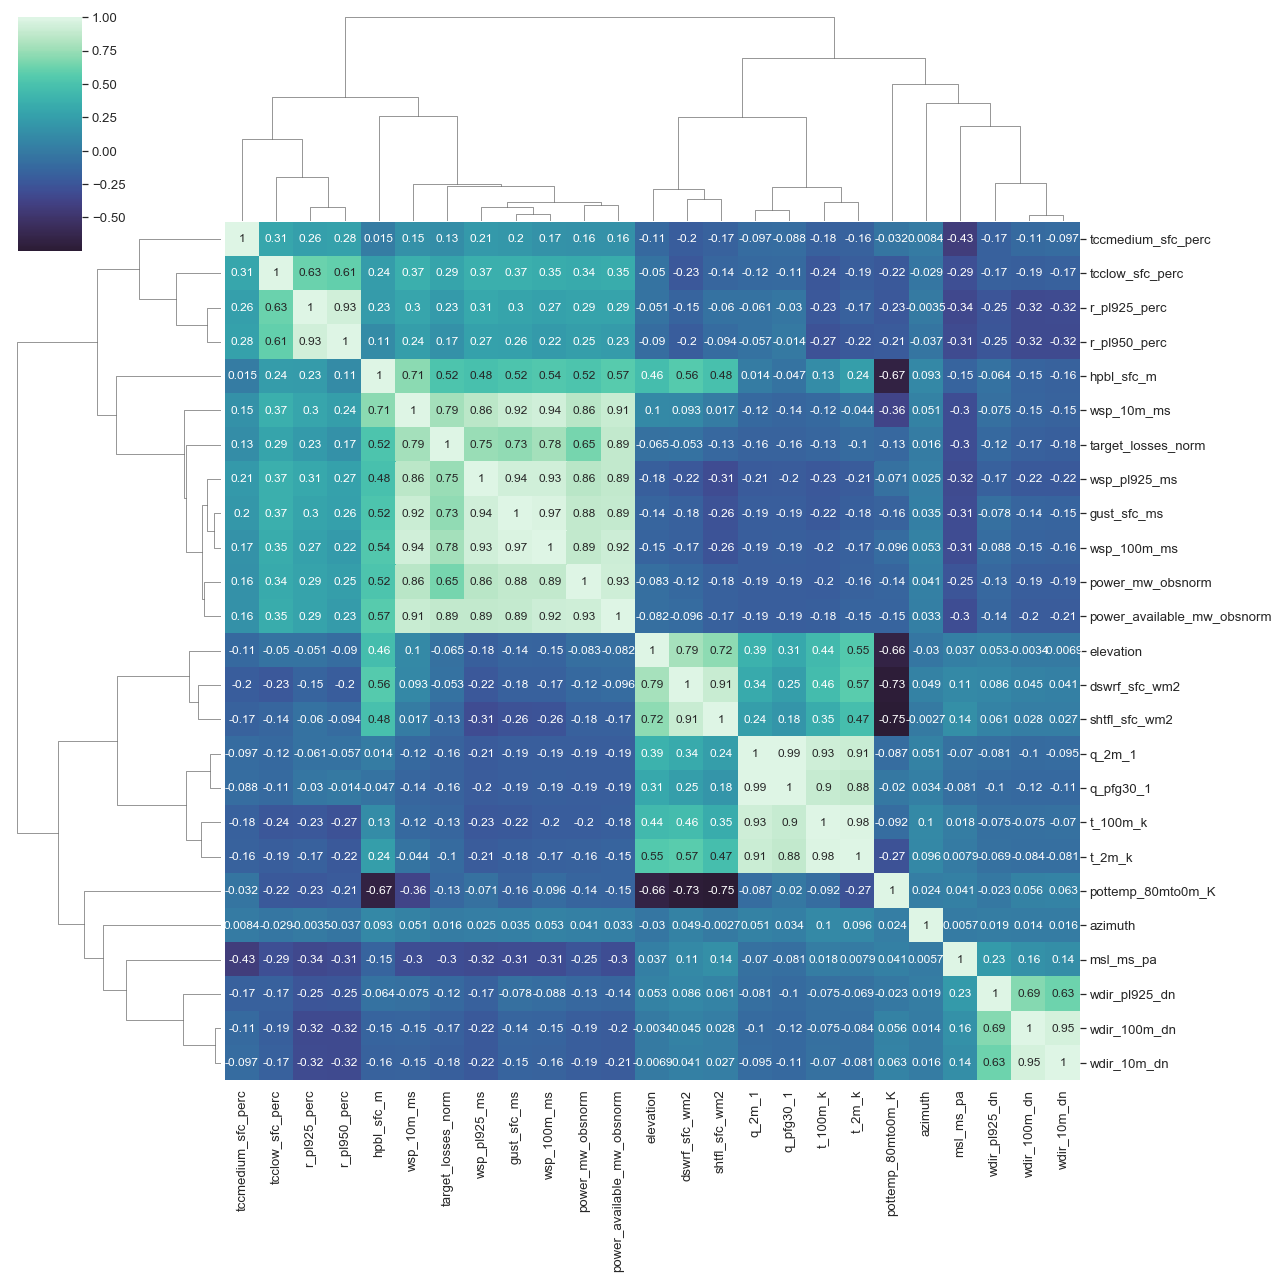

In [312]:
sns.set(font_scale=1.2)
sns.clustermap(df.corr(), cmap='mako', center=0.0, annot=True, annot_kws={'size': 12}, figsize=(18,18))
plt.show()

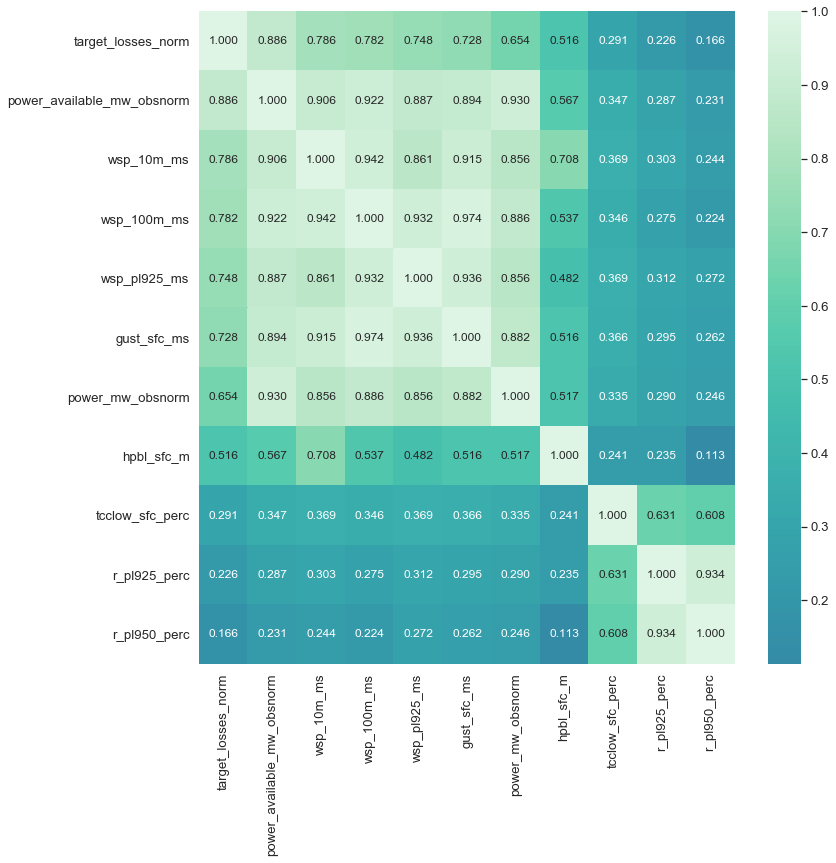

In [313]:
k = 11 #number of variables for heatmap
cols_corr_mat = df.corr().nlargest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.3f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



<function matplotlib.pyplot.show(*args, **kw)>

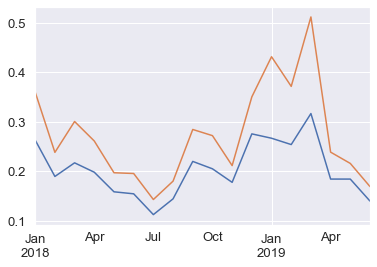

In [314]:
avg_pow = df['power_mw_obsnorm'].resample('M').mean()
avg_pot = df['power_available_mw_obsnorm'].resample('M').mean()
avg_pow.plot()
avg_pot.plot()
plt.show

In [ ]:
for i in month_name:
    avg_pow = df['power_mw_obsnorm'].resample('M').mean()
    avg_pot = df['power_available_mw_obsnorm'].resample('M').mean()
    avg_pow.plot()
    avg_pot.plot()
plt.show

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.



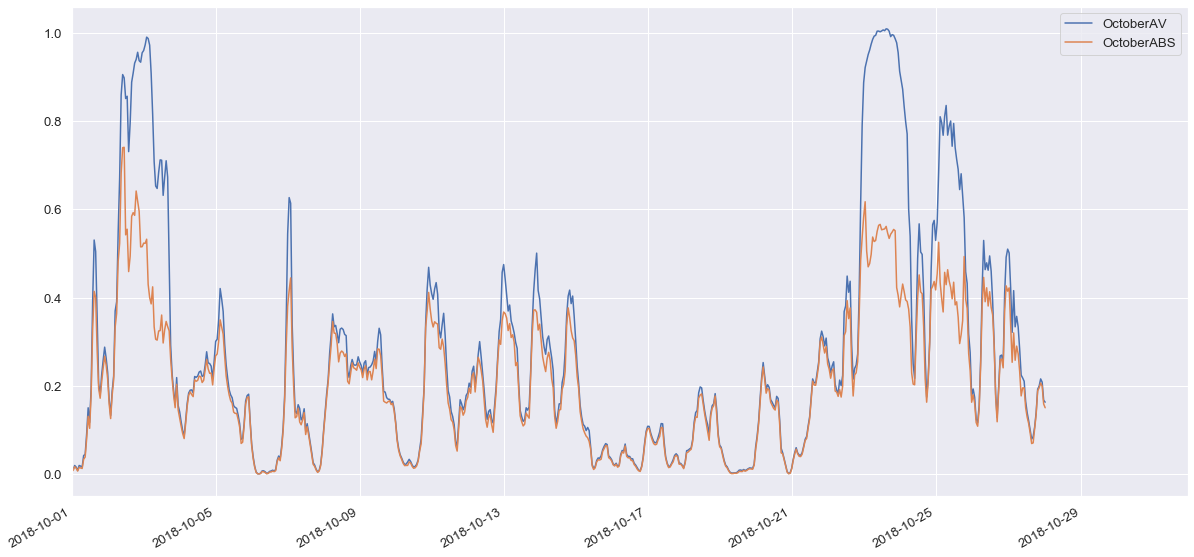

<Figure size 1440x720 with 0 Axes>

In [636]:
#days = ['Monday','Tuesday','Wednesday','Thursday', 'Friday']
month = ['October'#,'November','December'
        ]
for i in month:
    data = df.query('{} == 1'.format(i))
    avg_pow_av = data['power_available_mw_obsnorm'].resample('H').mean()
    avg_pow = data['power_mw_obsnorm'].resample('H').mean()
    avg_pow_av.plot(label=i+'AV',figsize=(20,10))
    avg_pow.plot(label=i+'ABS')
plt.legend()
plt.figure(figsize=(20,10.0))
plt.show()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future releas

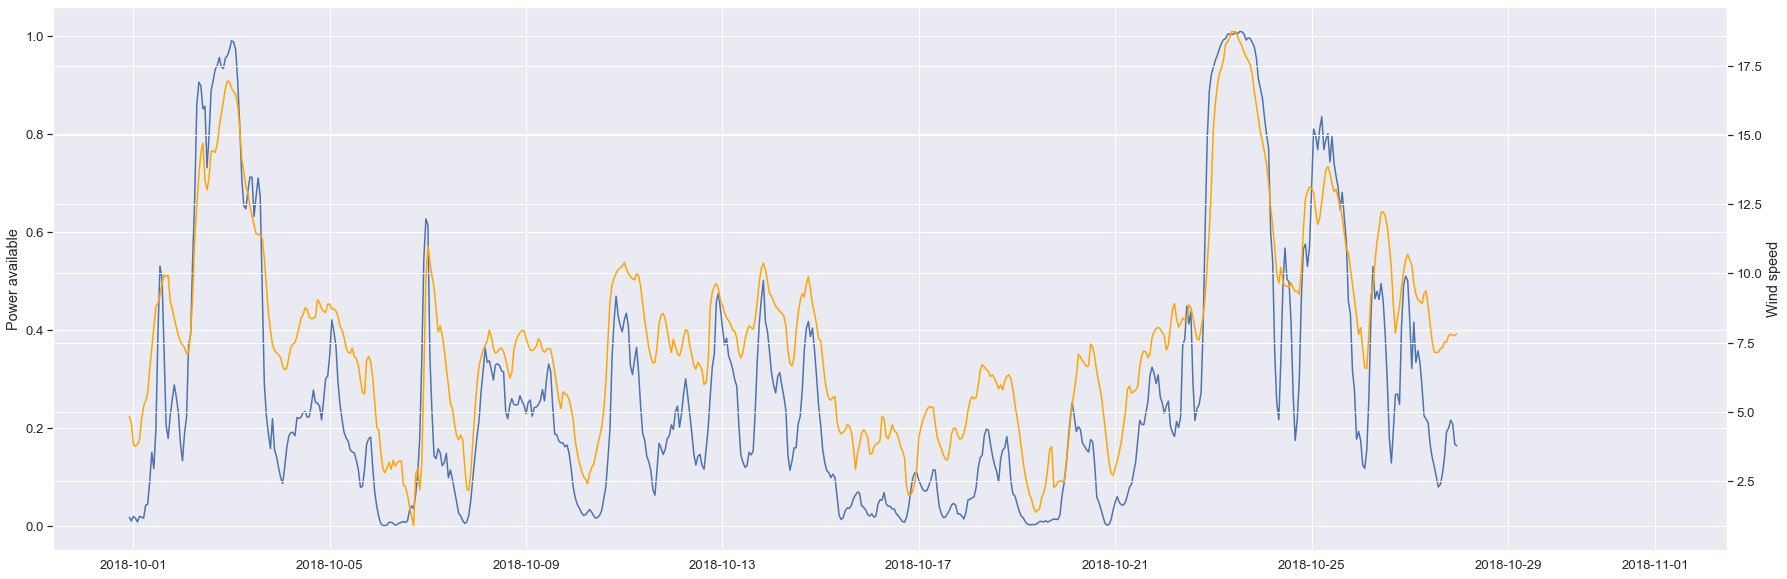

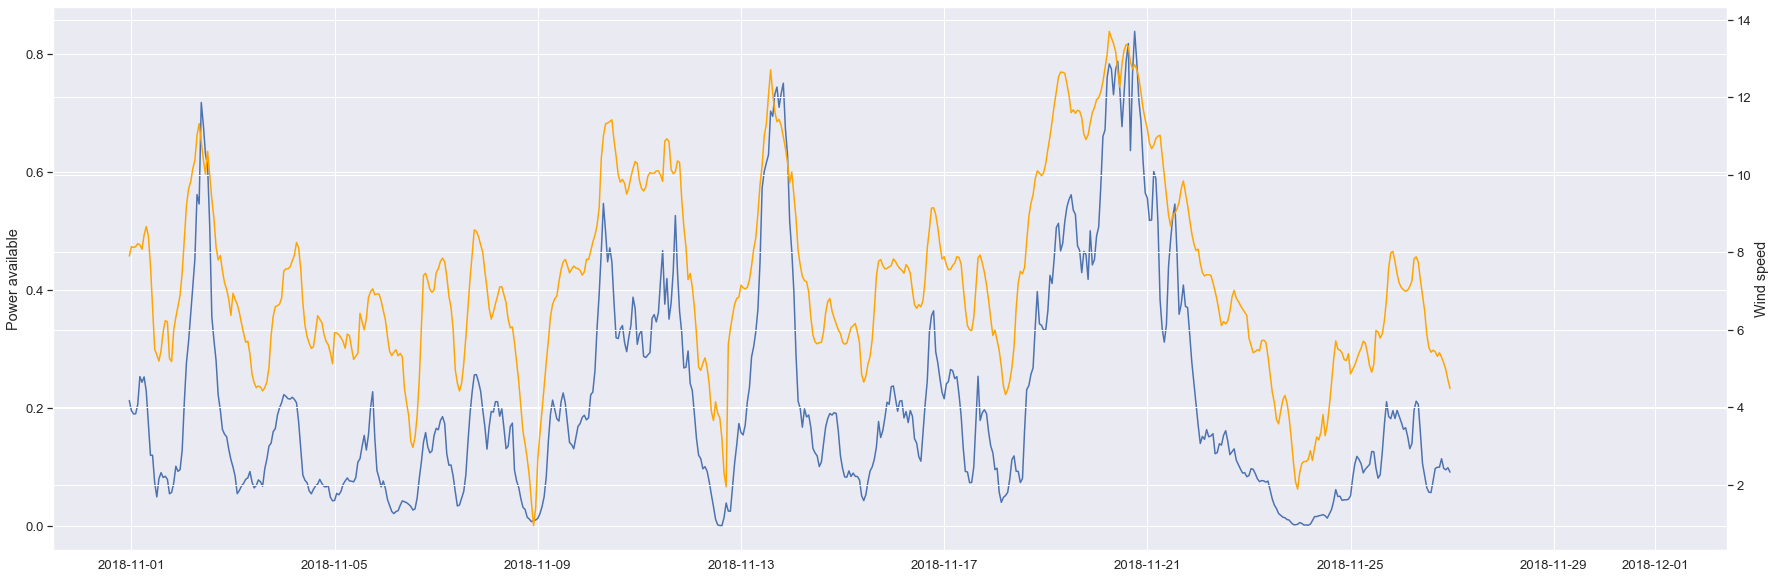

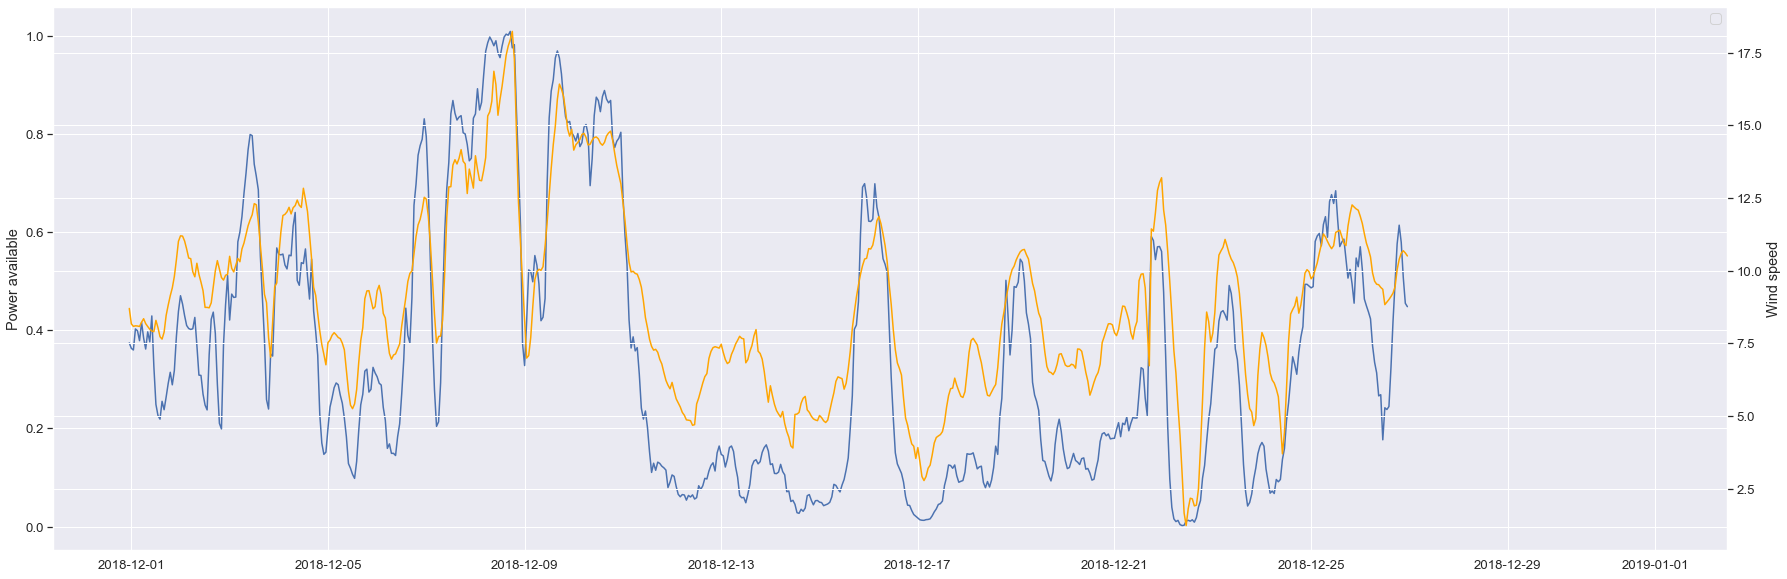

In [669]:
month = ['October','November','December'
        ]
for i in month:
    fig, ax1 = plt.subplots(figsize=(30,10))
    data = df.query('{} == 1'.format(i))
    avail = data['power_available_mw_obsnorm'].resample('H').mean()
    ax1.plot(avail,scalex='autoscale')
    ax1.set_ylabel('Power available')
    ax2 = ax1.twinx()
    wsp = data['wsp_100m_ms'].resample('H').mean()
    ax2.set_ylabel('Wind speed')
    ax2.plot(wsp,color='orange')
plt.legend()
plt.show()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



<function matplotlib.pyplot.show(*args, **kw)>

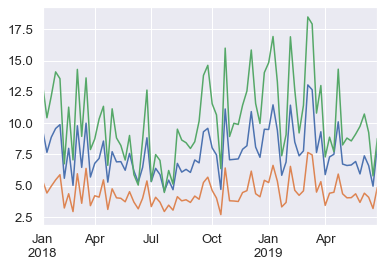

In [666]:
wsp = ['wsp_100m_ms','wsp_10m_ms','wsp_pl925_ms']
for i in wsp:
    avg_wsp = df[i].resample('W').mean()
    avg_wsp.plot()
plt.show

In [316]:
show_dist = ['dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa','pottemp_80mto0m_K', 'q_2m_1',
             'q_pfg30_1', 'r_pl925_perc','r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
             'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn','wdir_pl925_dn',
             'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms']

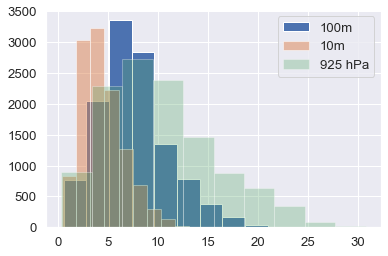

In [325]:
fig, ax = plt.subplots()
rects1 = ax.hist(x=df['wsp_100m_ms'],label='100m')
rects2 = ax.hist(x=df['wsp_10m_ms'],label='10m',alpha=0.5)
rects3 = ax.hist(x=df['wsp_pl925_ms'],label='925 hPa',alpha=0.3)
ax.legend()
plt.show()

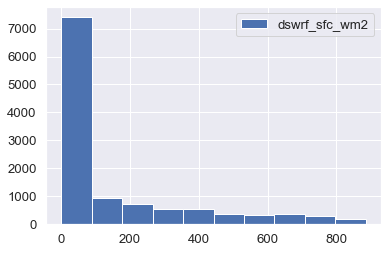

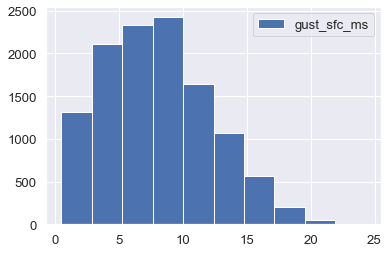

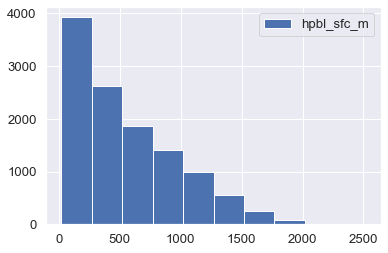

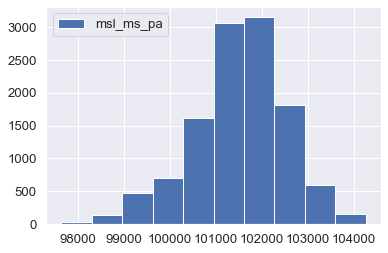

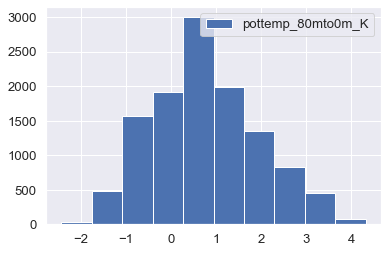

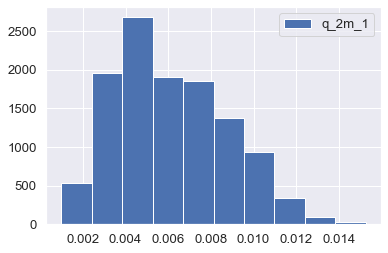

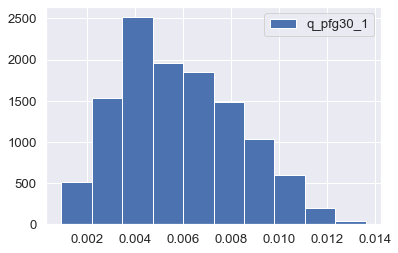

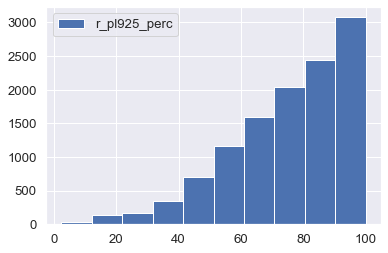

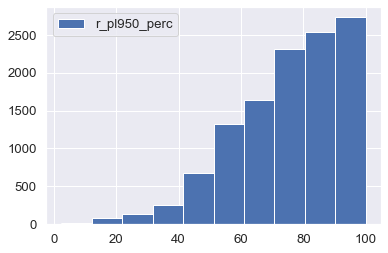

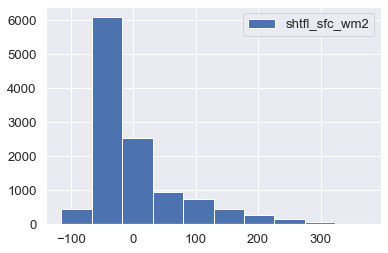

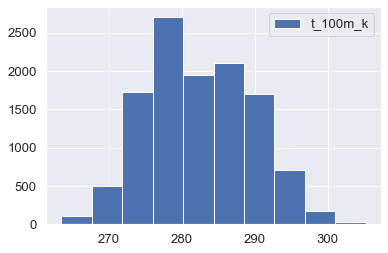

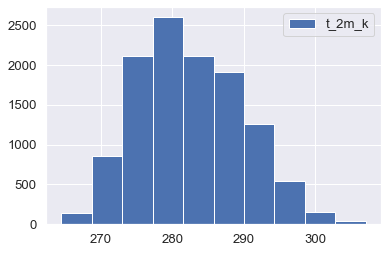

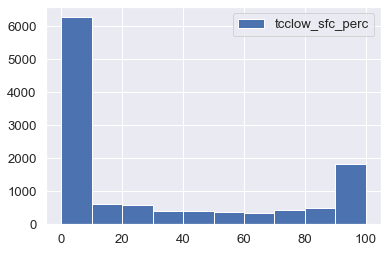

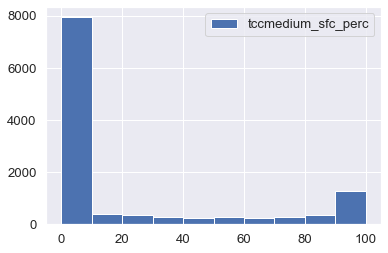

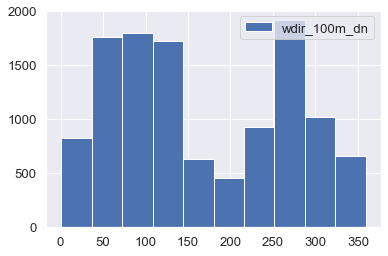

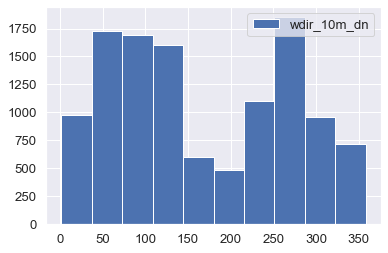

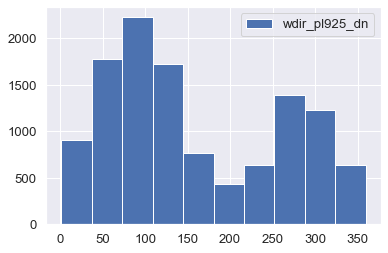

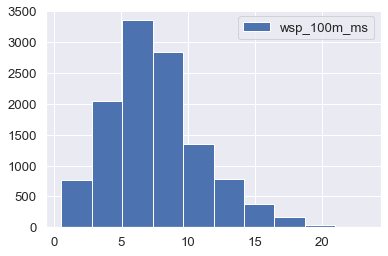

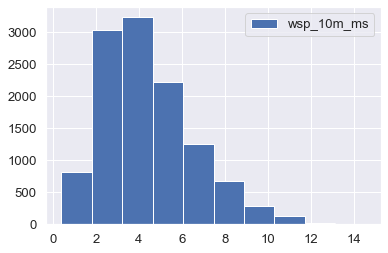

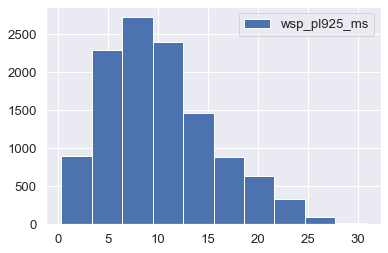

In [318]:
# distribution for each feature in base dataframe
for i in show_dist:
    fig, ax = plt.subplots()
    rects = ax.hist(x=df[i], label=i)
    ax.legend()
    plt.show()

In [319]:
num_features = ['dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa','pottemp_80mto0m_K', 'q_2m_1',
             'q_pfg30_1', 'r_pl925_perc','r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
             'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn','wdir_pl925_dn',
             'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms']

In [320]:
encoder = preprocessing.OneHotEncoder(dtype=np.int,categories=[['Monday','Tuesday','Wednesday','Thursday',
                                                                'Friday','Saturday','Sunday'],['January',
                                                                'February','March','April','May','June',
                                                                'July','August','September','October',
                                                                'November','December']])
onehotfeat = ['day_name','month_name']
for i in onehotfeat:
    cat_feat = pd.DataFrame(encoder.fit_transform(df[['day_name','month_name']]).toarray(),
                            columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
                                     'January','February','March','April','May','June','July','August',
                                     'September','October','November','December'])
cat_feat.index = df.index
df = pd.concat([df,cat_feat], axis=1)

In [361]:
def preproc(x_train):
    min_max = preprocessing.MinMaxScaler()
    x_preproc = min_max.fit_transform(x_train)
    return pd.DataFrame(x_preproc, columns=x_train.columns, index=x_train.index)

In [322]:
df

power_mw_obsnorm  power_available_mw_obsnorm  \
2018-01-01 07:00:00+01:00          0.512503                    0.966921   
2018-01-01 08:00:00+01:00          0.450723                    0.979995   
2018-01-01 09:00:00+01:00          0.501776                    0.985792   
2018-01-01 10:00:00+01:00          0.457684                    0.975297   
2018-01-01 11:00:00+01:00          0.478561                    0.969752   
2018-01-01 12:00:00+01:00          0.614915                    0.942335   
2018-01-01 13:00:00+01:00          0.543529                    0.896562   
2018-01-01 14:00:00+01:00          0.527852                    0.826681   
2018-01-01 15:00:00+01:00          0.504725                    0.746743   
2018-01-01 16:00:00+01:00          0.478161                    0.724066   
2018-01-01 17:00:00+01:00          0.473546                    0.685484   
2018-01-01 18:00:00+01:00          0.466272                    0.685143   
2018-01-01 19:00:00+01:00          0.409668                    0.616172   
2018-01-01 20:00:00+01:00          0.347872                    0.529728   
2018-01-01 21:00:00+01:00          0.301633                    0.364234   
2018-01-01 22:00:00+01:00          0.255851                    0.301627   
2018-01-01 23:00:00+01:00          0.235155                    0.270539   
2018-01-02 00:00:00+01:00          0.231717                    0.256800   
2018-01-02 01:00:00+01:00          0.187186                    0.200682   
2018-01-02 02:00:00+01:00          0.141489                    0.154737   
2018-01-02 03:00:00+01:00          0.132878                    0.143084   
2018-01-02 04:00:00+01:00          0.162488                    0.173336   
2018-01-02 05:00:00+01:00          0.167674                    0.178162   
2018-01-02 06:00:00+01:00          0.190002                    0.201777   
2018-01-02 07:00:00+01:00          0.209442                    0.223715   
2018-01-02 08:00:00+01:00          0.213840                    0.237857   
2018-01-02 09:00:00+01:00          0.195989                    0.251283   
2018-01-02 10:00:00+01:00          0.198484                    0.259105   
2018-01-02 11:00:00+01:00          0.215023                    0.262984   
2018-01-02 12:00:00+01:00          0.240528                    0.283307   
...                                     ...                         ...   
2019-06-23 20:00:00+02:00          0.143816                    0.169909   
2019-06-23 21:00:00+02:00          0.177557                    0.203194   
2019-06-23 22:00:00+02:00          0.189952                    0.225871   
2019-06-23 23:00:00+02:00          0.191671                    0.223486   
2019-06-24 00:00:00+02:00          0.208619                    0.240287   
2019-06-24 01:00:00+02:00          0.192297                    0.217749   
2019-06-24 02:00:00+02:00          0.164952                    0.200246   
2019-06-24 03:00:00+02:00          0.204475                    0.247993   
2019-06-24 04:00:00+02:00          0.159727                    0.195153   
2019-06-24 05:00:00+02:00          0.155382                    0.182998   
2019-06-24 06:00:00+02:00          0.168276                    0.185151   
2019-06-24 07:00:00+02:00          0.153904                    0.160777   
2019-06-24 08:00:00+02:00          0.134494                    0.150925   
2019-06-24 09:00:00+02:00          0.135264                    0.156622   
2019-06-24 10:00:00+02:00          0.140271                    0.153070   
2019-06-24 11:00:00+02:00          0.152759                    0.171181   
2019-06-24 12:00:00+02:00          0.153481                    0.174980   
2019-06-24 13:00:00+02:00          0.151325                    0.170686   
2019-06-24 14:00:00+02:00          0.144920                    0.171064   
2019-06-24 15:00:00+02:00          0.186517                    0.225815   
2019-06-24 16:00:00+02:00          0.210211                    0.281046   
2019-06-24 17:00:00+02:00          0.224319         

# Modelling

## Train test split

In [568]:
features =[#'dswrf_sfc_wm2', 
    'gust_sfc_ms',
    # 'hpbl_sfc_m', 'msl_ms_pa',
#       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
#       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
#       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
 #      'wdir_pl925_dn', 
    'wsp_100m_ms'
    , 'wsp_10m_ms', 'wsp_pl925_ms'
       #'created_on',
 #          'azimuth', 'elevation',
          ]    
X = df[features]
Y1 = df['power_mw_obsnorm']
Y2 = df['power_available_mw_obsnorm']
Y3 = df['target_losses_norm']

x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y1, test_size=0.25, random_state=5)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y2, test_size=0.25, random_state=5)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y3, test_size=0.25, random_state=5)

## Functions for evaluation and plotting

In [461]:
def regr_eval(y_test, y_pred, return_scores=False, print_scores=True):
    if print_scores==True:
        print('Mean squared error: '+str(round(mean_squared_error(y_test, y_pred),6)))
        print('Root mean squared error: '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),6)))
        print('Explained variance score: '+str(round(explained_variance_score(y_test, y_pred),6)))
        print('R-squared score: '+str(round(r2_score(y_test, y_pred),6)))
    if return_scores==True:
        return mean_squared_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred)),explained_variance_score(y_test, y_pred),r2_score(y_test, y_pred)

In [337]:
def plot_resid(y_test, y_pred):
    x = y_test.index
    y1 = y_test
    y2 = y_pred
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y1, name='True Values', line_color='#32a852', mode='markers'))
    fig.add_trace(go.Scatter(x=x, y=y2, name='Predicted Values', line_color='#23e2f7', mode='markers'))
    
    fig.show()

In [553]:
def plot_resid_hist(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=x, name='Distribution of errors'))
      
    fig.show()

In [557]:
def plot_resid_boxp(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Box(x=x, name='Distribution of errors'))
      
    fig.show()

## Linear Regression

In [569]:
# Prediction for power_mw_obsnorm
model = LinearRegression()
model = model.fit(x_train1, y_train1)
y_test1_pred = model.predict(x_test1)
regr_eval(y_test1, y_test1_pred, return_scores=False)

Mean squared error: 0.004948
Root mean squared error: 0.070342
Explained variance score: 0.809781
R-squared score: 0.809637


In [570]:
# Prediction for power_available_mw_obsnorm
model = LinearRegression()
model = model.fit(x_train2, y_train2)
y_test2_pred = model.predict(x_test2)
regr_eval(y_test2, y_test2_pred, return_scores=False)

Mean squared error: 0.008368
Root mean squared error: 0.091479
Explained variance score: 0.880031
R-squared score: 0.87981


In [571]:
# Prediction for target_losses_norm via model
model = LinearRegression()
model = model.fit(x_train3, y_train3)
y_test3_pred = model.predict(x_test3)
regr_eval(y_test3, y_test3_pred, return_scores=False)

Mean squared error: 0.005404
Root mean squared error: 0.073511
Explained variance score: 0.671974
R-squared score: 0.671734


In [466]:
plot_resid(y_test3, y_test3_pred)

In [574]:
plot_resid_hist(y_test3, y_test3_pred)

## Polynominal Linear Regression

In [575]:
x_train_poly1 = PolynomialFeatures(degree=2).fit_transform(x_train1)
x_test_poly1 = PolynomialFeatures(degree=2).fit_transform(x_test1)
model = LinearRegression()
model = model.fit(x_train_poly1, y_train1)
y_test1_pred = model.predict(x_test_poly1)
regr_eval(y_test1, y_test1_pred, return_scores=False)

Mean squared error: 0.004624
Root mean squared error: 0.067999
Explained variance score: 0.822258
R-squared score: 0.822107


In [576]:
x_train_poly2 = PolynomialFeatures(degree=2).fit_transform(x_train2)
x_test_poly2 = PolynomialFeatures(degree=2).fit_transform(x_test2)
model = LinearRegression()
model = model.fit(x_train_poly2, y_train2)
y_test2_pred = model.predict(x_test_poly2)
regr_eval(y_test2, y_test2_pred, return_scores=False)

Mean squared error: 0.007458
Root mean squared error: 0.08636
Explained variance score: 0.89306
R-squared score: 0.892886


In [577]:
x_train_poly3 = PolynomialFeatures(degree=2).fit_transform(x_train3)
x_test_poly3 = PolynomialFeatures(degree=2).fit_transform(x_test3)
model = LinearRegression()
model = model.fit(x_train_poly3, y_train3)
y_test3_pred = model.predict(x_test_poly3)
regr_eval(y_test3, y_test3_pred, return_scores=False)

Mean squared error: 0.003847
Root mean squared error: 0.062026
Explained variance score: 0.766428
R-squared score: 0.76629


## Support Vector Regressor

In [578]:
svr_model = SVR(kernel='rbf')
svr_model = svr_model.fit(x_train1, y_train1)
y_test1_pred = svr_model.predict(x_test1)
regr_eval(y_test1, y_test1_pred, return_scores=False)

Mean squared error: 0.004849
Root mean squared error: 0.069631
Explained variance score: 0.831369
R-squared score: 0.813462


In [581]:
svr_model = SVR(kernel='rbf')
svr_model = svr_model.fit(x_train2, y_train2)
y_test2_pred = svr_model.predict(x_test2)
regr_eval(y_test2, y_test2_pred, return_scores=False)


Mean squared error: 0.006653
Root mean squared error: 0.081564
Explained variance score: 0.910558
R-squared score: 0.904452


In [583]:
svr_model = SVR(kernel='rbf')
svr_model = svr_model.fit(x_train3, y_train3)
y_test3_pred = svr_model.predict(x_test3)
regr_eval(y_test3, y_test3_pred, return_scores=False)

Mean squared error: 0.00542
Root mean squared error: 0.07362
Explained variance score: 0.791709
R-squared score: 0.670758


In [586]:
regr_eval(y_test3, (y_test2_pred-y_test1_pred), return_scores=False)

Mean squared error: 0.002936
Root mean squared error: 0.054188
Explained variance score: 0.82168
R-squared score: 0.821624


## KNN

In [591]:
knn_model = KNeighborsRegressor(6)
knn_model = knn_model.fit(x_train1, y_train1)
y_test1_pred = knn_model.predict(x_test1)
regr_eval(y_test1, y_test1_pred, return_scores=False)

Mean squared error: 0.00403
Root mean squared error: 0.063483
Explained variance score: 0.844983
R-squared score: 0.84495


In [592]:
knn_model = KNeighborsRegressor(6)
knn_model = knn_model.fit(x_train2, y_train2)
y_test2_pred = knn_model.predict(x_test2)
regr_eval(y_test2, y_test2_pred, return_scores=False)

Mean squared error: 0.005906
Root mean squared error: 0.076853
Explained variance score: 0.915227
R-squared score: 0.915171


In [593]:
knn_model = KNeighborsRegressor(20)
knn_model = knn_model.fit(x_train3, y_train3)
y_test3_pred = knn_model.predict(x_test3)
regr_eval(y_test3, y_test3_pred, return_scores=False)

Mean squared error: 0.002766
Root mean squared error: 0.052597
Explained variance score: 0.832
R-squared score: 0.831946


In [594]:
plot_resid_boxp(y_test3, y_test3_pred)

In [602]:
y_test3_calc = y_test2_pred-y_test1_pred
regr_eval(y_test3, y_test3_pred, return_scores=False)
plot_resid_hist(y_test3, y_test3_pred)
plot_resid_boxp(y_test3, y_test3_pred)

Mean squared error: 0.002766
Root mean squared error: 0.052597
Explained variance score: 0.832
R-squared score: 0.831946


## Random Forrest Regressor

In [673]:
rfr_model = RandomForestRegressor(100)
rfr_model = rfr_model.fit(x_train1, y_train1)
y_test1_pred = rfr_model.predict(x_test1)
regr_eval(y_test1, y_test1_pred, return_scores=False)

Mean squared error: 0.003757
Root mean squared error: 0.061293
Explained variance score: 0.855499
R-squared score: 0.855463


In [674]:
rfr_model = RandomForestRegressor(100)
rfr_model = rfr_model.fit(x_train2, y_train2)
y_test2_pred = rfr_model.predict(x_test2)
regr_eval(y_test2, y_test2_pred, return_scores=False)

Mean squared error: 0.005647
Root mean squared error: 0.075149
Explained variance score: 0.91892
R-squared score: 0.918891


In [672]:
rfr_model = RandomForestRegressor(100)
rfr_model = rfr_model.fit(x_train3, y_train3)
y_test3_pred = rfr_model.predict(x_test3)
regr_eval(y_test3, y_test3_pred, return_scores=False)

Mean squared error: 0.002849
Root mean squared error: 0.053375
Explained variance score: 0.827041
R-squared score: 0.826935


In [676]:
plot_resid(y_test3, y_test3_pred)
plot_resid_hist(y_test3, y_test3_pred)
plot_resid_boxp(y_test3, y_test3_pred)

 ## Principal Component Analysis

## K-Means